# Optimal sub_architecture with the derived spectra


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, explained_variance_score

import keras

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv1D,MaxPooling1D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from livelossplot.tf_keras import PlotLossesCallback


In [2]:
def set_reproducible():
    np.random.seed(12345)
    random.seed(12345)
    tf.random.set_seed(12345)
    
set_reproducible()

In [3]:
dps1200 = pd.read_csv("dpsDeriv1200.csv")

In [4]:
features = dps1200.iloc[:, 4:].values
labels = dps1200.iloc[:, 0].values

In [5]:
def convertToDecade(y:int) -> int: 
    return int(str(y)[:3])

def calculate_sample_weights(y_train):

    decades = [convertToDecade(year) for year in y_train]

    unique_decades, counts = np.unique(decades, return_counts=True)
    total_samples = len(y_train)
    
    weights = {}
    for decade, count in zip(unique_decades, counts):
        weights[decade] = 1 - count/total_samples

    sample_weights = []
    for year in y_train:
        sample_weights.append(weights[convertToDecade(year)])
        
    return np.array(sample_weights)

In [6]:
def build_model(DenseN, DropoutR, C1_K, C1_S, C2_K, C2_S, C3_K, C3_S, input_dim):

    activation1='relu'
    activation2='linear'
    
    model = keras.Sequential()
    model.add(keras.layers.Input((input_dim, 1)))
    model.add(keras.layers.GaussianNoise(0.0001))

    model.add(keras.layers.Conv1D(C1_K, (C1_S), padding='valid', activation=activation1))
    model.add(keras.layers.Conv1D(C2_K, (C2_S), padding='valid', activation=activation1))
    model.add(keras.layers.Conv1D(C3_K, (C3_S), padding='valid', activation=activation1))
    model.add(MaxPooling1D(pool_size=2))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(DropoutR))
    
    model.add(keras.layers.Dense(DenseN, activation=activation1))
    model.add(keras.layers.Dense(DenseN, activation=activation1))
    model.add(keras.layers.Dense(DenseN, activation=activation1))
    model.add(keras.layers.Dense(1, activation=activation2))

    model.compile(loss=tf.keras.losses.Huber(), optimizer=keras.optimizers.Adam(learning_rate=0.004), metrics=['mean_absolute_error'])
    
    return model


In [7]:
## Define the Huber distance (source DeepChemometrics)
def huber(y_true, y_pred, delta=1.0):
    return np.mean(delta**2*( (1+((y_true-y_pred)/delta)**2)**0.5 -1))

# Crossvalidation

Since NN training involves random sampling and weights initialization (in this case), it is usefull to use cross-validation.

In [9]:
## Compute error metrics
def error_metrices(y_true_train, y_predicted_train, y_true_test, y_predicted_test):
    rmse_train = np.sqrt(mean_squared_error(y_true_train, y_predicted_train))
    rmse_test = np.sqrt(mean_squared_error(y_true_test, y_predicted_test))
    R2_train= r2_score(y_true_train, y_predicted_train)
    R2_test= r2_score(y_true_test, y_predicted_test)
    hub_train = huber(y_true_train, y_predicted_train)
    hub_test = huber(y_true_test, y_predicted_test)

    print('*********** Benchmark results ***********\n')
    print(f"R2    (Train/Test) = {R2_train:.3f} / {R2_test:.3f}")
    print(f"RMSE  (Train/Test) = {rmse_train:.3f} / {rmse_test:.3f}")
    print(f"Huber (Train/Test) = {hub_train:.3f} / {hub_test:.3f}")

    return (rmse_train, rmse_test, R2_train, R2_test, hub_train, hub_test)

class ModelWithData:
    def __init__(self, model, train_x, train_label, train_predicted, test_x, test_label, test_predicted, score:float, iteration) -> None:
        self.model = model
        self.train_x = train_x
        self.train_label = train_label
        self.train_predicted = train_predicted
        self.test_x = test_x
        self.test_label = test_label
        self.test_predicted = test_predicted
        self.score = score
        self.iteration = iteration

    def isBetter(self, otherScore: float) -> bool:
        return otherScore < 0 or (self.score >= 0 and self.score <= otherScore)

In [10]:

def evaluations_of_models(features, labels, DenseN, DropoutR, C1_K, C1_S, C2_K, C2_S, C3_K, C3_S):

    x = np.array(features)
    y = np.array(labels)
    input_dim = 410
    epochs = 1000
    
    # generate model
    model = build_model(DenseN, DropoutR, C1_K, C1_S, C2_K, C2_S, C3_K, C3_S, input_dim)

    # Define the number of folds for Cross-Validation
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    scores_train = { "rmse": [], "r2": [], "huber": []}
    scores_test = { "rmse": [], "r2": [], "huber": []}


    monitor = EarlyStopping(monitor='val_loss', min_delta=4e-5, patience=50, verbose=0, mode='auto', restore_best_weights=True)
    rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)

    bestMwd = ModelWithData(None, 0, 0, 0, 0, 0, 0, -1, 0)
    
    # Iterate through the models
    i = 0
    for train_index, test_index in skf.split(x, y):
        i = i + 1
        print(f'\n\n> Iteration {i}')

        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Training the CNN-Model on X_train_fold, y_train_fold

        sample_weight=calculate_sample_weights(y_train)
        g = model.fit(x_train, y_train, epochs=epochs, batch_size=45, validation_data=(x_test, y_test), verbose=0, callbacks=[rdlr, monitor], sample_weight=sample_weight)

        # Evaluation of the model on X_test_fold, y_test_fold
        accuracy = model.evaluate(x_test, y_test, verbose=0)
        print(f'Fold Accuracy: {accuracy}')

        # Analyse error metrics

        train_pred = model.predict(x_train, verbose=0)
        test_pred = model.predict(x_test, verbose=0)

        (rmse_train, rmse_test, r2_train, r2_test, huber_train, huber_test) = error_metrices(y_train, train_pred, y_test, test_pred)

        mwd = ModelWithData(g, x_train, y_train, train_pred, x_test, y_test, test_pred, rmse_train, i)

        if mwd.isBetter(bestMwd.score):
            bestMwd = mwd

        scores_train["rmse"].append(rmse_train)
        scores_train["r2"].append(r2_train)
        scores_train["huber"].append(huber_train)

        scores_test["rmse"].append(rmse_test)
        scores_test["r2"].append(r2_test)
        scores_test["huber"].append(huber_test)

    ## clear session 
    tf.keras.backend.clear_session()

    scores_train_mean = {}
    scores_test_mean = {}
    num_model = len(scores_train["rmse"])

    for metric in scores_train.keys():
        scores_train_mean[metric] = np.mean(scores_train[metric])
        scores_test_mean[metric] = np.mean(scores_test[metric])
        print(f'Train: {metric} (mean of {num_model} models)= {scores_train_mean[metric]} \nTest: {metric} (mean of {num_model} models)= {scores_test_mean[metric]}')

    return bestMwd

In [11]:
bestMwd = evaluations_of_models(features, labels, DenseN=351, DropoutR=0.0, C1_K=55, C1_S=45, C2_K=43, C2_S=36, C3_K=63, C3_S=1)
print(f"Best model is from iteration {bestMwd.iteration}")

d:\programming\python\first_steps_with_cnns\tensor\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(




> Iteration 1

Epoch 51: ReduceLROnPlateau reducing learning rate to 0.0020000000949949026.

Epoch 76: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
Fold Accuracy: [154.2705535888672, 158.99734497070312]
*********** Benchmark results ***********

R2    (Train/Test) = -0.019 / -0.023
RMSE  (Train/Test) = 198.692 / 196.620
Huber (Train/Test) = 160.537 / 158.113


> Iteration 2

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Fold Accuracy: [182.98431396484375, 179.04708862304688]
*********** Benchmark results ***********

R2    (Train/Test) = -0.142 / -0.151
RMSE  (Train/Test) = 210.054 / 209.838
Huber (Train/Test) = 178.944 / 178.120


> Iteration 3

Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Fold Accuracy: [163.39004516601562, 161.1408233642578]
*********** Benchmark results ***********

R2    (Train/Test) = -0.039 / -0.034
RMSE  (Train/Test) = 199.844 / 200.708
Huber (Train/Test) = 160.237 / 160.260


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


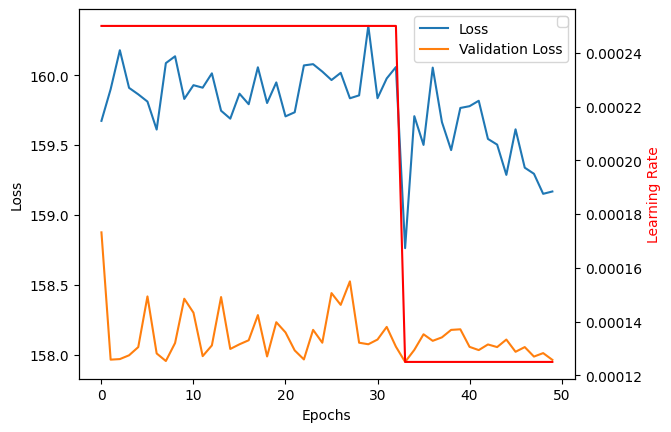

In [12]:
plt.plot(bestMwd.model.history['loss'], label='Loss')
plt.plot(bestMwd.model.history['val_loss'], label='Validation Loss')

#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(bestMwd.model.history['learning_rate'], color='r')
ax2.set_ylabel('Learning Rate',color='r')

Eval_of_model = plt.legend()

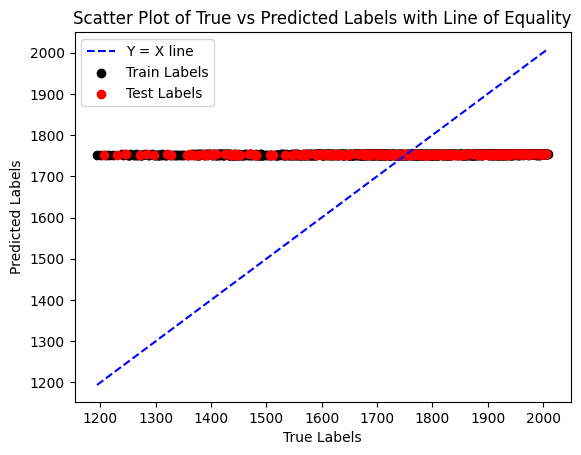

In [13]:
# Create an array of x-values ranging from the minimum to maximum of the data
x_values = np.linspace(min(labels), max(labels), 100)

# Plot the line of equality (y=x)
plt.plot(x_values, x_values, color='blue', linestyle='--', label='Y = X line')

# Scatter plot for predicted values
plt.scatter(bestMwd.train_label, bestMwd.train_predicted, c='k', label='Train Labels')
plt.scatter(bestMwd.test_label, bestMwd.test_predicted, c='r', label='Test Labels')

# Labels, legend, and title
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.legend()
plt.title('Scatter Plot of True vs Predicted Labels with Line of Equality')

# Show the plot
plt.show()